In [189]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
tqdm.pandas()
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
import gc

/usr/local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
test_df = pd.read_csv('datasets/test.csv.gz', dtype={'ID': np.int32,
                                                    'shop_id': np.int32,
                                                    'item_id': np.int32})
test_df

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [3]:
item_df = pd.read_csv('datasets/items.csv')
item_df

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [4]:
sales_df = pd.read_csv('datasets/sales_train.csv.gz')
sales_df['date'] = pd.to_datetime(sales_df['date'], format='%d.%m.%Y')
sales_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [5]:
sales_df.isna().sum(axis=0)

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


<AxesSubplot:xlabel='date'>

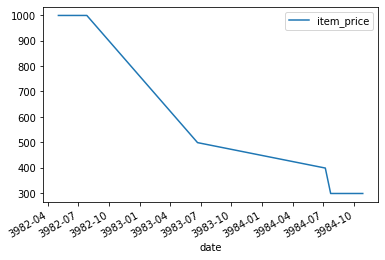

In [6]:
sample_item = sales_df.sample(1, random_state=123)
shop_id = sample_item['shop_id'].values[0]
item_id = sample_item['item_id'].values[0]
item_sales_df = sales_df[(sales_df['shop_id'] == shop_id) & (sales_df['item_id'] == item_id)].sort_values('date')
item_sales_df.plot(x='date', y='item_price')

In [7]:

def downcast_dataframe(df):
    dtype_mapper = {
        'int64': 'int32',
        'float64': 'float32'
    }
    dtypes = df.dtypes.to_dict()

    new_dtypes = {col: dtype_mapper.get(str(dtype), str(dtype)) for col, dtype in dtypes.items()}
    return df.astype(new_dtypes)

In [8]:
monthly_sales_df = sales_df.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False) \
                            .agg({'item_price': 'mean', 'item_cnt_day': 'sum'})
monthly_sales_df.rename(columns={'item_cnt_day': 'count'}, inplace=True)
del sales_df, item_sales_df
gc.collect()
monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count
0,0,30,1,265.0,31.0
1,0,31,1,434.0,11.0
2,0,32,0,221.0,6.0
3,0,32,1,221.0,10.0
4,0,33,0,347.0,3.0
...,...,...,...,...,...
1609119,59,22164,27,699.0,2.0
1609120,59,22164,30,699.0,1.0
1609121,59,22167,9,299.0,1.0
1609122,59,22167,11,299.0,2.0


<AxesSubplot:xlabel='item_price', ylabel='count'>

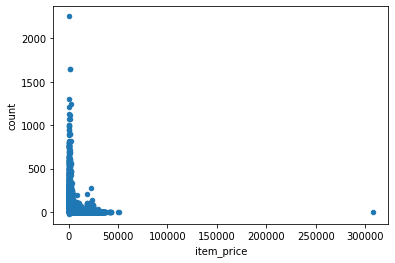

In [9]:
# prices = resampled_sales_df['item_price']
# counts = resampled_sales_df['item_cnt_day']

# resampled_sales_df = resampled_sales_df[((prices > prices.quantile(0.01)) & (prices < prices.quantile(0.99))) &
#                                         ((counts > counts.quantile(0.01)) & (counts < counts.quantile(0.99)))]
monthly_sales_df.plot.scatter(x='item_price', y='count')

In [10]:
monthly_sales_df = monthly_sales_df.merge(item_df[['item_id', 'item_category_id']], on='item_id')
monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count,item_category_id
0,0,30,1,265.0,31.0,40
1,1,30,1,265.0,10.0,40
2,2,30,2,359.0,1.0,40
3,2,30,5,399.0,1.0,40
4,2,30,15,169.0,1.0,40
...,...,...,...,...,...,...
1609119,59,9760,12,179.0,1.0,37
1609120,59,12846,10,149.0,1.0,37
1609121,59,16270,6,1000.0,1.0,75
1609122,59,17732,9,198.0,1.0,28


In [11]:

monthly_sales_df = downcast_dataframe(monthly_sales_df)

In [12]:
monthly_sales_df.describe()

,shop_id,item_id,date_block_num,item_price,count,item_category_id
count,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06
mean,3.280585e+01,1.068099e+04,1.466479e+01,7.908846e+02,2.267200e+00,4.154192e+01
std,1.653701e+01,6.238883e+03,9.542322e+00,1.551605e+03,8.649882e+00,1.632365e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e-02,-2.200000e+01,0.000000e+00
25%,2.100000e+01,5.045000e+03,6.000000e+00,1.990000e+02,1.000000e+00,3.000000e+01
50%,3.100000e+01,1.049700e+04,1.400000e+01,3.990000e+02,1.000000e+00,4.000000e+01
75%,4.700000e+01,1.606000e+04,2.300000e+01,8.985000e+02,2.000000e+00,5.500000e+01
max,5.900000e+01,2.216900e+04,3.300000e+01,3.079800e+05,2.253000e+03,8.300000e+01


### Prove the sales of any shop are different and unique

Text(0, 0.5, 'item_count')

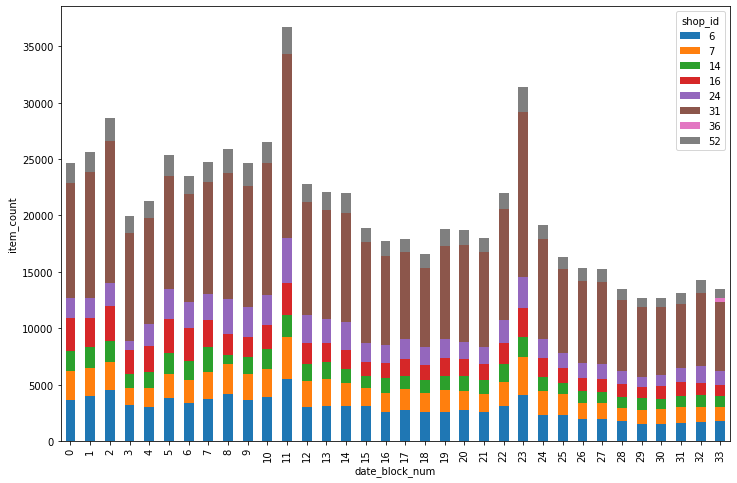

In [56]:
shop_ids = monthly_sales_df['shop_id']
selected_shop_ids = shop_ids.drop_duplicates().sample(8, random_state=99)

ax = monthly_sales_df[shop_ids.isin(selected_shop_ids)].groupby(['date_block_num', 'shop_id']).agg(
    {'count': 'sum'}).unstack().plot.bar(y='count', stacked=True, figsize=(12, 8))
ax.set_ylabel('item_count')

### Prove the sales of any item categories are different

<AxesSubplot:xlabel='date_block_num'>

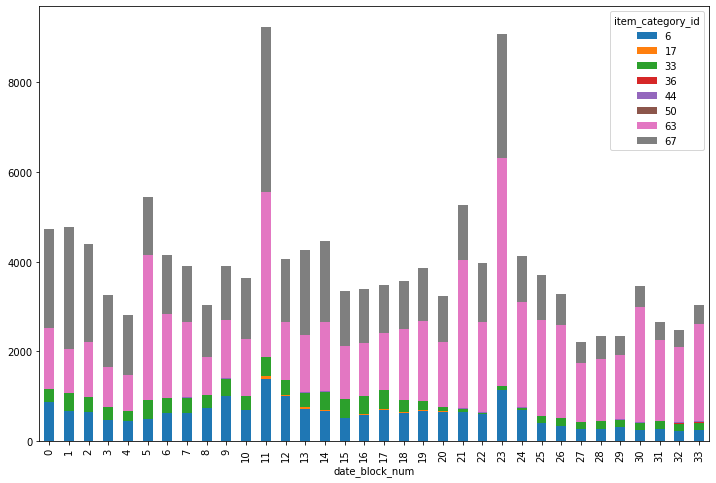

In [58]:
categories = monthly_sales_df['item_category_id']
selected_categories = categories.drop_duplicates().sample(8, random_state=1)
monthly_sales_df[categories.isin(selected_categories)].groupby(['date_block_num', 'item_category_id']).agg(
    {'count': 'sum'}).unstack().plot.bar(y='count', stacked=True, figsize=(12, 8))

### Distribution

In [59]:
def IQR(data, lower, upper):
    return data[(data > data.quantile(lower)) & (data < data.quantile(upper))]


<AxesSubplot:>

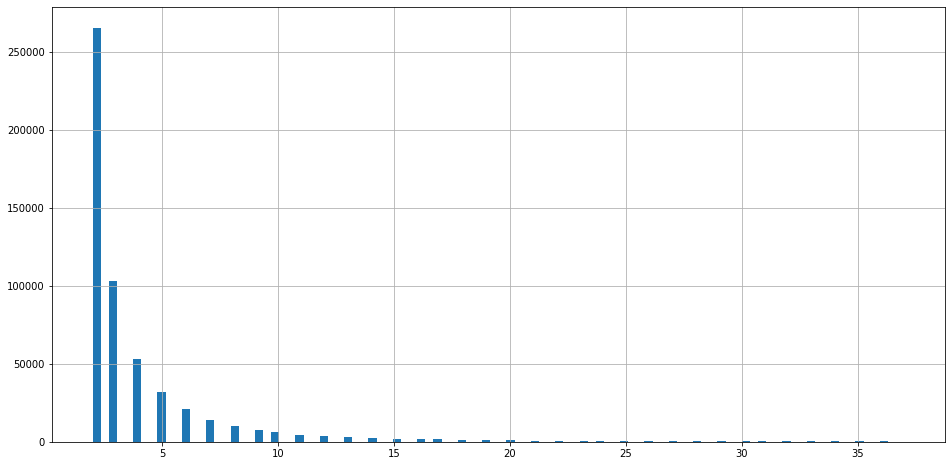

In [60]:
alpha = 0.0027
IQR(monthly_sales_df['count'], alpha, 1-alpha).hist(bins=100, figsize=(16, 8))

<AxesSubplot:>

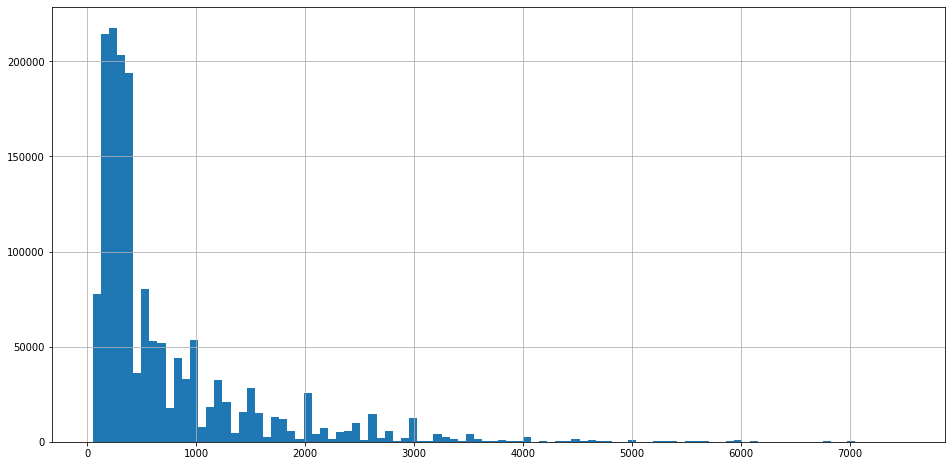

In [61]:
alpha = 0.008
IQR(monthly_sales_df['item_price'], alpha, 1-alpha).hist( bins=100, figsize=(16, 8))

In [62]:
monthly_sales_df.set_index(['shop_id', 'item_id', 'date_block_num']).head(20)

item_price  count  item_category_id
shop_id item_id date_block_num                                     
0       30      1                    265.0   31.0                40
1       30      1                    265.0   10.0                40
2       30      2                    359.0    1.0                40
                5                    399.0    1.0                40
                15                   169.0    1.0                40
                16                   169.0    1.0                40
3       30      1                    399.0    4.0                40
                2                    399.0    5.0                40
                3                    399.0    2.0                40
                4                    399.0    2.0                40
                5                    399.0    1.0                40
                9                    169.0    1.0                40
                10                   169.0    1.0                40
                11                   169.0    2.0                40
                12                   169.0    1.0                40
                30                   129.0    1.0                40
4       30      1                    399.0    7.0                40
                2                    399.0    3.0                40
                7                    399.0    1.0                40
5       30      1                    399.0    5.0                40

In [63]:
monthly_sales_df.nunique()

shop_id                60
item_id             21807
date_block_num         34
item_price          41464
count                 446
item_category_id       84
dtype: int64

In [64]:
test_df.nunique()

ID         214200
shop_id        42
item_id      5100
dtype: int64

In [65]:
gc.collect()

122

### Clip count

<AxesSubplot:ylabel='Frequency'>

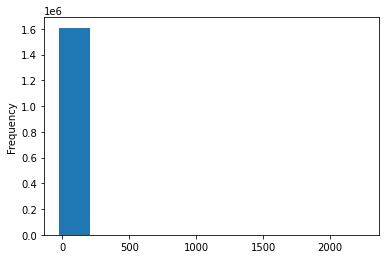

In [13]:
monthly_sales_df['count'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

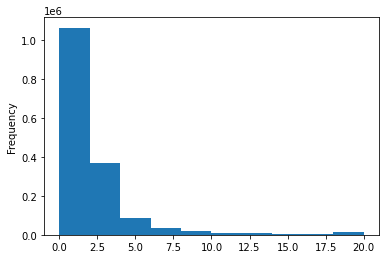

In [14]:
monthly_sales_df['count'].clip(0, 20, inplace=True)
monthly_sales_df['count'].plot.hist()

### Create monthly_sales_df backup 

In [15]:
_monthly_sales_df = monthly_sales_df.copy()

In [16]:
_monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count,item_category_id
0,0,30,1,265.0,20.0,40
1,1,30,1,265.0,10.0,40
2,2,30,2,359.0,1.0,40
3,2,30,5,399.0,1.0,40
4,2,30,15,169.0,1.0,40
...,...,...,...,...,...,...
1609119,59,9760,12,179.0,1.0,37
1609120,59,12846,10,149.0,1.0,37
1609121,59,16270,6,1000.0,1.0,75
1609122,59,17732,9,198.0,1.0,28


## Feature Engineering

### Generate Grid features


In [25]:
from itertools import product

In [116]:
monthly_sales_df = _monthly_sales_df.copy()
grid = [] 

unique_shops = test_df['shop_id'].unique()
unique_items = test_df['item_id'].unique()

# unique_shops = monthly_sales_df['shop_id'].unique()
# unique_items = monthly_sales_df['item_id'].unique()

unique_block_nums = monthly_sales_df['date_block_num'].unique()

grid.append(np.array(list(product(*[unique_shops, unique_items, unique_block_nums])),dtype='int32'))
# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns=['shop_id', 'item_id', 'date_block_num'],dtype=np.int32)
data = grid.merge(monthly_sales_df, how='left', on=['shop_id', 'item_id', 'date_block_num'])
# data.fillna(fillna_series, inplace=True)
del grid
gc.collect()

464

In [177]:
# Fill item price
def fill_nan_by_date_block( df):
    df['item_price'] = df['item_price'].ffill().bfill().fillna(0)
    return df
data = data.sort_values('date_block_num')
data = data.groupby(['shop_id', 'item_id'], as_index=False).progress_apply(lambda group: fill_nan_by_date_block(group))

data.fillna({'count': 0, 'item_category_id': data['item_category_id'].max()+1}, inplace=True)


100%|██████████| 214200/214200 [03:04<00:00, 1160.85it/s]


In [193]:
_data = data.copy()
data

,shop_id,item_id,date_block_num,item_price,count,item_category_id
3641399,42,969,0,549.0,0.0,84.0
2566523,21,9894,0,349.0,0.0,84.0
2566489,21,8391,0,449.0,0.0,84.0
2566455,21,9425,0,349.0,0.0,84.0
2566421,21,3344,0,2999.0,0.0,84.0
...,...,...,...,...,...,...
1089460,10,11575,33,75.0,0.0,84.0
6213226,38,11113,33,0.0,0.0,84.0
7085836,39,7541,33,0.0,0.0,84.0
1617106,31,15374,33,98.0,0.0,84.0


### Create date block feature

In [192]:
def generate_feature(df, by, base_col, output_col, agg_func):
    agg_df = df.groupby(by, as_index=False).agg({base_col: agg_func})
    agg_df.rename(columns={base_col: output_col}, inplace=True)
    return df.merge(agg_df, how='left', on=by)

In [194]:
data = _data.copy()
data = generate_feature(data, by=[
    'shop_id', 'date_block_num'], base_col='count', output_col='count_by_shop', agg_func='sum')
data = generate_feature(data, by=[
    'item_id', 'date_block_num'], base_col='count', output_col='count_by_item', agg_func='sum')
data = generate_feature(data, by=[
    'item_category_id', 'date_block_num'], base_col='count', output_col='count_by_item_cat', agg_func='sum')

data = generate_feature(data, by=[
    'shop_id', 'date_block_num'], base_col='item_price', output_col='avg_shop_price', agg_func='mean')
data = generate_feature(data, by=[
    'item_id', 'date_block_num'], base_col='item_price', output_col='avg_item_price', agg_func='mean')
data = generate_feature(data, by=[
    'item_category_id', 'date_block_num'], base_col='item_price', output_col='avg_item_cat_price', agg_func='mean')
data


,shop_id,item_id,date_block_num,item_price,count,item_category_id,count_by_shop,count_by_item,count_by_item_cat,avg_shop_price,avg_item_price,avg_item_cat_price
0,42,969,0,549.0,0.0,84.0,864.0,0.0,0.0,759.885376,479.715179,532.315430
1,21,9894,0,349.0,0.0,84.0,335.0,0.0,0.0,661.685608,265.904755,532.315430
2,21,8391,0,449.0,0.0,84.0,335.0,0.0,0.0,661.685608,351.595245,532.315430
3,21,9425,0,349.0,0.0,84.0,335.0,0.0,0.0,661.685608,24.928572,532.315430
4,21,3344,0,2999.0,0.0,84.0,335.0,0.0,0.0,661.685608,2654.801270,532.315430
...,...,...,...,...,...,...,...,...,...,...,...,...
7282795,10,11575,33,75.0,0.0,84.0,417.0,22.0,0.0,297.520966,115.142860,393.984467
7282796,38,11113,33,0.0,0.0,84.0,1017.0,6.0,0.0,521.088074,177.071426,393.984467
7282797,39,7541,33,0.0,0.0,84.0,827.0,1.0,0.0,467.732544,16.642857,393.984467
7282798,31,15374,33,98.0,0.0,84.0,5022.0,0.0,0.0,747.882202,223.361908,393.984467


### Mean Encoding

In [195]:
def mean_encoding(df, cat_col, target_col):
    encoder = df.groupby(cat_col)[target_col].mean()
    return df[cat_col].map(encoder)
data['shop_id_encoded'] = mean_encoding(data, 'shop_id', 'count')
data['item_id_encoded'] = mean_encoding(data, 'item_id', 'count')
data['item_category_id_encoded'] = mean_encoding(data, 'item_category_id', 'count')
data

,shop_id,item_id,date_block_num,item_price,count,item_category_id,count_by_shop,count_by_item,count_by_item_cat,avg_shop_price,avg_item_price,avg_item_cat_price,shop_id_encoded,item_id_encoded,item_category_id_encoded
0,42,969,0,549.0,0.0,84.0,864.0,0.0,0.0,759.885376,479.715179,532.315430,0.368899,0.158263,0.0
1,21,9894,0,349.0,0.0,84.0,335.0,0.0,0.0,661.685608,265.904755,532.315430,0.193310,0.054622,0.0
2,21,8391,0,449.0,0.0,84.0,335.0,0.0,0.0,661.685608,351.595245,532.315430,0.193310,0.158263,0.0
3,21,9425,0,349.0,0.0,84.0,335.0,0.0,0.0,661.685608,24.928572,532.315430,0.193310,0.002101,0.0
4,21,3344,0,2999.0,0.0,84.0,335.0,0.0,0.0,661.685608,2654.801270,532.315430,0.193310,0.240896,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7282795,10,11575,33,75.0,0.0,84.0,417.0,22.0,0.0,297.520966,115.142860,393.984467,0.071073,0.317227,0.0
7282796,38,11113,33,0.0,0.0,84.0,1017.0,6.0,0.0,521.088074,177.071426,393.984467,0.168408,0.061625,0.0
7282797,39,7541,33,0.0,0.0,84.0,827.0,1.0,0.0,467.732544,16.642857,393.984467,0.062278,0.028011,0.0
7282798,31,15374,33,98.0,0.0,84.0,5022.0,0.0,0.0,747.882202,223.361908,393.984467,0.715461,0.115546,0.0


### Standardization

In [220]:
standard_cols = ['item_price', 'count', 'count_by_shop', 'count_by_item',
                 'count_by_item_cat', 'avg_shop_price', 'avg_item_price', 'avg_item_cat_price',
                 'shop_id_encoded', 'item_id_encoded', 'item_category_id_encoded'
                ]
standard_cols = list(filter(lambda col: col in data.columns, standard_cols))
scaler = StandardScaler()
data.loc[:, standard_cols] = scaler.fit_transform(data[standard_cols])
data

,shop_id,item_id,date_block_num,item_price,count,item_category_id,count_by_shop,count_by_item,count_by_item_cat,avg_shop_price,avg_item_price,avg_item_cat_price,shop_id_encoded,item_id_encoded,item_category_id_encoded
0,42,969,0,0.016140,-0.179743,84.0,-0.115678,-0.252319,-0.23553,1.580639,-0.038026,0.015641,1.376639,-0.063108,-0.261772
1,21,9894,0,-0.121687,-0.179743,84.0,-0.770237,-0.252319,-0.23553,0.918181,-0.215300,0.015641,0.042309,-0.284977,-0.261772
2,21,8391,0,-0.052773,-0.179743,84.0,-0.770237,-0.252319,-0.23553,0.918181,-0.144253,0.015641,0.042309,-0.063108,-0.261772
3,21,9425,0,-0.121687,-0.179743,84.0,-0.770237,-0.252319,-0.23553,0.918181,-0.415097,0.015641,0.042309,-0.397411,-0.261772
4,21,3344,0,1.704521,-0.179743,84.0,-0.770237,-0.252319,-0.23553,0.918181,1.765374,0.015641,0.042309,0.113788,-0.261772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7282795,10,11575,33,-0.310510,-0.179743,84.0,-0.668774,0.451660,-0.23553,-1.538483,-0.340299,-0.305529,-0.886599,0.277192,-0.261772
7282796,38,11113,33,-0.362195,-0.179743,84.0,0.073637,-0.060324,-0.23553,-0.030294,-0.288953,-0.305529,-0.146926,-0.269986,-0.261772
7282797,39,7541,33,-0.362195,-0.179743,84.0,-0.161460,-0.220320,-0.23553,-0.390231,-0.421967,-0.305529,-0.953432,-0.341944,-0.261772
7282798,31,15374,33,-0.294659,-0.179743,84.0,5.029230,-0.252319,-0.23553,1.499665,-0.250573,-0.305529,4.010240,-0.154554,-0.261772


In [239]:
def inverse_scaling(prediction, col):
    mean, var = scaler_params.loc[col].tolist()
    prediction = prediction * np.sqrt(var) + mean
    return prediction
scaler_params = pd.DataFrame([scaler.mean_, scaler.var_], columns=standard_cols, index=['mean', 'var']).T
scaler_params

,mean,var
item_price,525.578654,2.105675e+06
count,0.187743,1.090997e+00
count_by_shop,957.488095,6.531513e+05
count_by_item,7.885196,9.766220e+02
count_by_item_cat,260.452494,1.222824e+06
avg_shop_price,525.578655,2.197375e+04
avg_item_price,525.578655,1.454685e+06
avg_item_cat_price,525.578656,1.855104e+05
shop_id_encoded,0.187743,1.731666e-02
item_id_encoded,0.187743,2.182087e-01


### Generate past-features

In [221]:
timeserie_cols = [
    'item_price', 'count', 'count_by_shop', 'count_by_item',
    'count_by_item_cat', 'avg_shop_price', 'avg_item_price', 'avg_item_cat_price'
]
def generate_past_features(data, lookback_steps):
    index_cols = ['shop_id', 'item_id', 'date_block_num']
#     timeserie_cols = list(data.columns.difference(index_cols + ['item_category_id']))

#     new_data = data.copy()
    new_data = data[data['date_block_num'] >= max(lookback_steps)]

    for lookback_num in tqdm(lookback_steps):
        month_shift_df = data.copy()
        month_shift_df['date_block_num'] = month_shift_df['date_block_num'] + lookback_num

        lookback_cols = [f'p{lookback_num}_{col}' for col in timeserie_cols]
        month_shift_df.rename(columns={old_col: new_col for old_col, new_col in zip(timeserie_cols, lookback_cols)}, inplace=True)
        month_shift_df = month_shift_df[month_shift_df.columns.sort_values()]
        new_data = new_data.merge(
            month_shift_df[index_cols+lookback_cols], how='left', on=index_cols)
    return new_data

### Cross validation split

In [222]:
lookback_steps = np.array([1, 2, 3, 4, 5, 6, 9 ]) 

In [223]:

# val_blocks = [30, 31, 32]
val_blocks = [32]

train_val_data = generate_past_features(data, lookback_steps)
train_data = train_val_data[(train_val_data['date_block_num'] >= 0) & (train_val_data['date_block_num'] < min(val_blocks))]
val_data = train_val_data[train_val_data['date_block_num'].isin(val_blocks)]
# del data

target_col = 'count'
feature_cols = train_data.columns.difference(
    [target_col, 'date_block_num', 'item_price',
     'count_by_shop', 'count_by_item', 'count_by_item_cat',
     'avg_shop_price', 'avg_item_price', 'avg_item_cat_price',
     'shop_id', 'item_id', 'item_category_id'
    ]).sort_values().to_list()

X_train = train_data[feature_cols]
Y_train = train_data[target_col]

X_val = val_data[feature_cols]
Y_val = val_data[target_col]

del train_val_data, train_data, val_data
gc.collect()

100%|██████████| 7/7 [00:45<00:00,  6.44s/it]


45

In [224]:
X_train

,item_category_id_encoded,item_id_encoded,p1_avg_item_cat_price,p1_avg_item_price,p1_avg_shop_price,p1_count,p1_count_by_item,p1_count_by_item_cat,p1_count_by_shop,p1_item_price,...,p6_item_price,p9_avg_item_cat_price,p9_avg_item_price,p9_avg_shop_price,p9_count,p9_count_by_item,p9_count_by_item_cat,p9_count_by_shop,p9_item_price,shop_id_encoded
0,-0.261772,0.008850,-0.000375,0.342258,0.207464,-0.179743,-0.252319,-0.235530,-0.532665,0.326251,...,0.326251,0.015641,0.342258,0.243842,-0.179743,-0.252319,-0.235530,-0.726929,0.326251,-0.146926
1,-0.261772,-0.401908,-0.000375,-0.435766,0.156227,-0.179743,-0.252319,-0.235530,-0.443576,-0.362195,...,-0.362195,0.015641,-0.435766,0.187112,-0.179743,-0.252319,-0.235530,-0.427490,-0.362195,-0.163054
2,-0.261772,-0.259492,-0.000375,-0.432805,2.094340,-0.179743,-0.252319,-0.235530,1.176117,-0.362195,...,-0.362195,0.015641,-0.432805,2.144804,-0.179743,-0.252319,-0.235530,0.691076,-0.362195,2.841610
3,-0.261772,0.167756,-0.000375,-0.265639,0.207464,-0.179743,-0.252319,-0.235530,-0.532665,-0.204383,...,-0.204383,0.015641,-0.265639,0.243842,-0.179743,-0.252319,-0.235530,-0.726929,-0.204383,-0.146926
4,-0.261772,0.127280,-0.000375,-0.066835,0.156227,-0.179743,-0.252319,-0.235530,-0.443576,-0.018316,...,-0.018316,0.015641,-0.066835,0.187112,-0.179743,-0.252319,-0.235530,-0.427490,-0.018316,-0.163054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4926595,-0.261772,-0.313460,-0.179235,-0.140008,-0.202413,-0.179743,-0.220320,-0.235530,0.133030,-0.362195,...,-0.362195,-0.144162,-0.130118,-0.132036,-0.179743,-0.156322,-0.235530,0.344617,-0.362195,-0.047006
4926596,4.640641,3.882570,0.044507,-0.084752,0.383772,0.777646,0.003674,4.327625,0.634157,-0.052773,...,-0.052773,0.048596,-0.084555,0.471242,0.777646,1.795619,6.278224,0.825947,-0.052773,0.181715
4926597,-0.261772,-0.070603,-0.633575,-0.338700,0.279133,0.777646,0.067672,5.550253,-0.103304,-0.259513,...,-0.259513,-0.144162,-0.338774,0.375701,-0.179743,1.251636,-0.235530,0.055077,-0.259513,-0.124488
4926598,-0.261772,0.229220,-0.179235,-0.183024,1.344213,-0.179743,0.067672,-0.235530,2.391197,-0.121687,...,-0.121687,-0.526898,-0.211648,1.437093,0.777646,0.195668,5.677762,2.714145,-0.156143,2.108774


In [225]:
test_lookback_steps = lookback_steps - 1

test_block = data['date_block_num'].max()
test_data = data[data['date_block_num'] >= test_block - max(test_lookback_steps)]
test_data = generate_past_features(test_data, test_lookback_steps)
test_data = test_data[test_data['date_block_num'] == test_block]
test_data = test_df.merge(test_data, how='left', on=['shop_id', 'item_id'])


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


In [226]:
feature_cols = test_data.columns.difference(
    [target_col, 'ID', 'date_block_num', 'item_price',
     'count_by_shop', 'count_by_item', 'count_by_item_cat',
     'avg_shop_price', 'avg_item_price', 'avg_item_cat_price',
     'shop_id', 'item_id', 'item_category_id'
    ]).sort_values().to_list()
X_test = test_data[feature_cols]

# del test_data
gc.collect()
X_test

,item_category_id_encoded,item_id_encoded,p0_avg_item_cat_price,p0_avg_item_price,p0_avg_shop_price,p0_count,p0_count_by_item,p0_count_by_item_cat,p0_count_by_shop,p0_item_price,...,p5_item_price,p8_avg_item_cat_price,p8_avg_item_price,p8_avg_shop_price,p8_count,p8_count_by_item,p8_count_by_item_cat,p8_count_by_shop,p8_item_price,shop_id_encoded
0,-0.261772,1.301089,-0.305529,0.507278,-0.415715,-0.179743,0.547657,-0.235530,0.063738,0.154312,...,0.532992,-0.154318,1.448039,-0.240414,-0.179743,0.771650,-0.235530,-0.187444,1.015386,-0.432006
1,-0.261772,-0.401908,-0.305529,-0.435766,-0.415715,-0.179743,-0.252319,-0.235530,0.063738,-0.362195,...,-0.362195,-0.154318,-0.435766,-0.240414,-0.179743,-0.252319,-0.235530,-0.187444,-0.362195,-0.432006
2,3.502423,0.329661,2.395937,0.392078,-0.415715,0.777646,1.091640,1.918540,0.063738,0.464078,...,0.257338,-0.154318,0.263697,-0.240414,-0.179743,-0.252319,-0.235530,-0.187444,0.257338,-0.432006
3,-0.261772,-0.192032,-0.305529,0.273083,-0.415715,-0.179743,0.643654,-0.235530,0.063738,0.050597,...,0.050597,-0.154318,0.056455,-0.240414,-0.179743,-0.252319,-0.235530,-0.187444,0.050597,-0.432006
4,-0.261772,-0.401908,-0.305529,-0.435766,-0.415715,-0.179743,-0.252319,-0.235530,0.063738,-0.362195,...,-0.362195,-0.154318,-0.435766,-0.240414,-0.179743,-0.252319,-0.235530,-0.187444,-0.362195,-0.432006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,1.811440,0.286187,-0.456642,-0.351393,-0.537547,0.777646,-0.188321,4.891011,-0.359436,-0.293970,...,-0.225057,-0.508164,-0.292171,-0.378623,0.777646,2.499598,5.034796,-0.443576,-0.225057,-0.542181
214196,-0.261772,-0.395912,-0.305529,-0.336511,-0.537547,-0.179743,-0.220320,-0.235530,-0.359436,-0.362195,...,-0.362195,-0.154318,-0.336511,-0.378623,-0.179743,-0.252319,-0.235530,-0.443576,-0.362195,-0.542181
214197,-0.261772,0.046328,-0.305529,-0.277286,-0.537547,-0.179743,-0.092323,-0.235530,-0.359436,-0.225057,...,-0.225057,-0.508164,-0.292092,-0.378623,0.777646,0.003674,5.034796,-0.443576,-0.225057,-0.542181
214198,-0.261772,-0.328452,-0.305529,-0.404887,-0.537547,-0.179743,-0.188321,-0.235530,-0.359436,-0.362195,...,-0.362195,-0.154318,-0.404496,-0.378623,-0.179743,-0.156322,-0.235530,-0.443576,-0.362195,-0.542181


## Baseline Model

In [206]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

In [227]:
rfr = RandomForestRegressor(n_estimators=100,
                            max_depth=16,
                            max_features='sqrt',
                            min_samples_split=2,
                            verbose=100,
                            random_state=42,
                            n_jobs=-1)

In [228]:
rfr.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100building tree 4 of 100
building tree 5 of 100building tree 6 of 100
building tree 7 of 100


building tree 8 of 100
building tree 9 of 100[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.3s

building tree 10 of 100[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.7s

building tree 11 of 100[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   18.6s

building tree 12 of 100[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   25.0s

building tree 13 of 100[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   25.7s

building tree 14 of 100[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   26.6s

building tree 15 of 100[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   27.3s

building tree 16 of 100[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   30.4s

building tree 17 of 100[Parallel(n_jobs=-1)]: Do

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished


RandomForestRegressor(max_depth=16, max_features='sqrt', n_jobs=-1,
                      random_state=42, verbose=100)

In [242]:
prediction = rfr.predict(X_val)
prediction = inverse_scaling(prediction, 'count')
prediction

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.1s
[Para

array([1.42795370e-09, 1.46902868e-01, 2.48622445e-02, ...,
       1.29151519e-02, 1.42795370e-09, 7.64493651e-02])

In [212]:
metrics = {'rmse': lambda *args: mean_squared_error(*args, squared=False),
           'r2': r2_score
          }
result = pd.Series({name: metric(inverse_scaling(Y_val, 'count'), prediction) for name, metric in metrics.items()})
result

rmse    0.635815
r2      0.675303
dtype: float64

<AxesSubplot:>

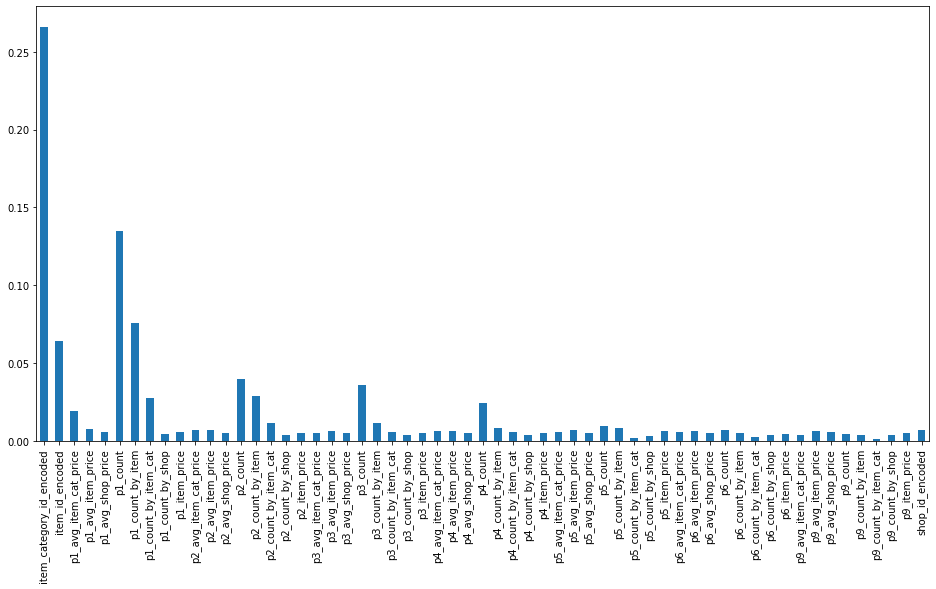

In [213]:

pd.Series(rfr.feature_importances_, index=X_train.columns).plot.bar(figsize=(16, 8))

### LightGBM

In [56]:
import lightgbm as lgb

In [76]:


# categorical_features = ['shop_id', 'item_id', 'item_category_id']
train_lgb_data = lgb.Dataset(X_train, label=Y_train, )
params = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'num_leaves': 900,
    'n_estimators': 100,
    'sub_feature': 0.2,
    'metric': 'mse'
    
}
lgb_model = lgb.train(params, train_lgb_data, )



/usr/local/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.612187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12959
[LightGBM] [Info] Number of data points in the train set: 4926600, number of used features: 59
[LightGBM] [Info] Start training from score -0.350164


In [77]:
prediction = lgb_model.predict(X_val, )
prediction = inverse_scaling(prediction, 'count')
metrics = {'rmse': lambda *args: mean_squared_error(*args, squared=False),
           'r2': r2_score
          }
result = pd.Series({name: metric(inverse_scaling(Y_val, 'count'), prediction) for name, metric in metrics.items()})
result

rmse    0.618550
r2      0.584782
dtype: float64

<AxesSubplot:>

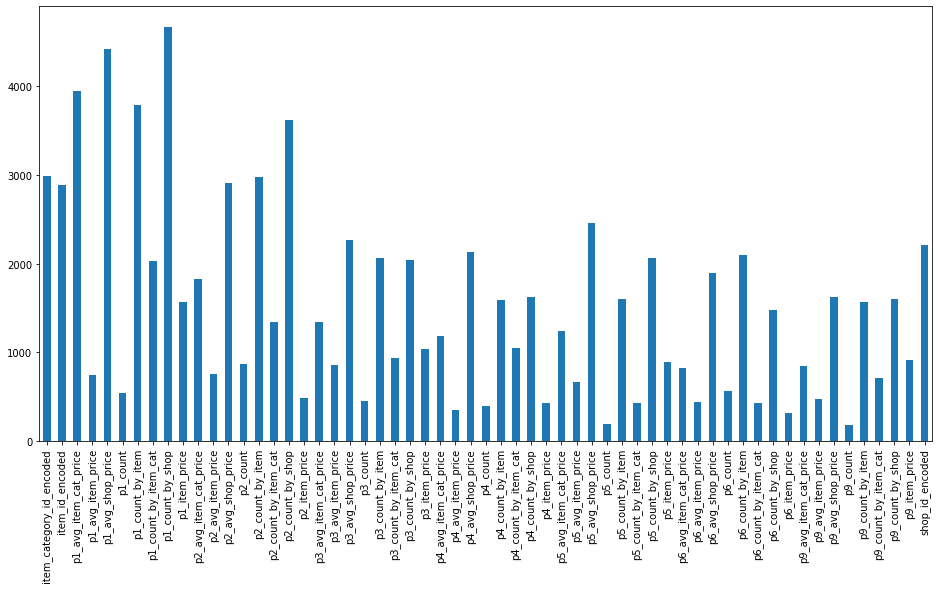

In [60]:

pd.Series(lgb_model.feature_importance(), index=X_train.columns).plot.bar(figsize=(16, 8))



### Lightgbm Hyper parameter search

In [187]:
params = {
    'max_depth': [16, 64,  -1],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [16, 50, 100,],
    'n_estimators': [40, 100],
    'subsample': [1],
    'subsample_freq': [1],
    'metric': ['mse']
}

def score_func(y_true, y_pred):
    y_true = inverse_scaling(y_true, 'count')
    y_pred = inverse_scaling(y_pred, 'count')
    return mean_squared_error(y_true, y_pred, squared=False)

lgb_model = lgb.LGBMRegressor(silent=False)
gs = GridSearchCV(lgb_model,
                  param_grid=params,
                  cv=5,
                  n_jobs=-1,
                  verbose=10,
                  scoring=make_scorer(score_func, greater_is_better=False)
                 )


In [188]:
gs.fit(X_train, Y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 42.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 51.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 55

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.548128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13264
[LightGBM] [Info] Number of data points in the train set: 4498200, number of used features: 59
[LightGBM] [Info] Start training from score -0.135977


GridSearchCV(cv=5, estimator=LGBMRegressor(silent=False), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [16, 64, -1], 'metric': ['mse'],
                         'n_estimators': [40, 100], 'num_leaves': [16, 50, 100],
                         'subsample': [1], 'subsample_freq': [1]},
             scoring=make_scorer(score_func, greater_is_better=False),
             verbose=10)

In [190]:
gs.best_estimator_

LGBMRegressor(max_depth=64, metric='mse', num_leaves=50, silent=False,
              subsample=1, subsample_freq=1)

In [196]:
best_param = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').iloc[0]['params']
best_param

{'learning_rate': 0.1,
 'max_depth': -1,
 'metric': 'mse',
 'n_estimators': 100,
 'num_leaves': 50,
 'subsample': 1,
 'subsample_freq': 1}

In [189]:
import joblib
joblib.dump(gs, 'lgb_gridsearch.pickle')

['lgb_gridsearch.pickle']

In [199]:
categorical_features = ['shop_id', 'item_id', 'item_category_id']
train_lgb_data = lgb.Dataset(X_train, label=Y_train, categorical_feature=categorical_features)
lgb_model = lgb.train(best_param, train_lgb_data, )


/usr/local/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.416888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18031
[LightGBM] [Info] Number of data points in the train set: 4498200, number of used features: 59
[LightGBM] [Info] Start training from score -0.135977


In [200]:
prediction = lgb_model.predict(X_val, categorical_feature=categorical_features)
prediction = inverse_scaling(prediction, 'count')
metrics = {'rmse': lambda *args: mean_squared_error(*args, squared=False),
           'r2': r2_score
          }
result = pd.Series({name: metric(inverse_scaling(Y_val, 'count'), prediction) for name, metric in metrics.items()})
result

rmse    1.376958
r2      0.605059
dtype: float64

### Predict

In [216]:


prediction = rfr.predict(X_test) 
# prediction = inverse_scaling(prediction, 'count')



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.1s
[Para

In [217]:
submission_df = pd.DataFrame(np.array([test_data['ID'].values, prediction]).T,
                             columns=['ID', 'item_cnt_month'], )
submission_df['ID'] = submission_df['ID'].astype(int)
submission_df

,ID,item_cnt_month
0,0,0.169032
1,1,0.000000
2,2,1.754338
3,3,0.074246
4,4,0.000000
...,...,...
214195,214195,1.051766
214196,214196,0.000000
214197,214197,0.007571
214198,214198,0.000000


<AxesSubplot:>

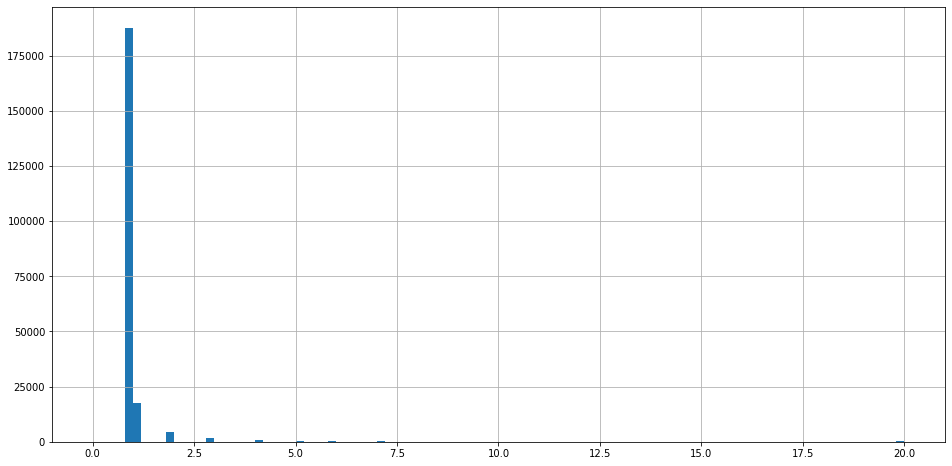

In [69]:
inverse_scaling(Y_val, 'count').hist(bins=100, figsize=(16, 8))

<AxesSubplot:>

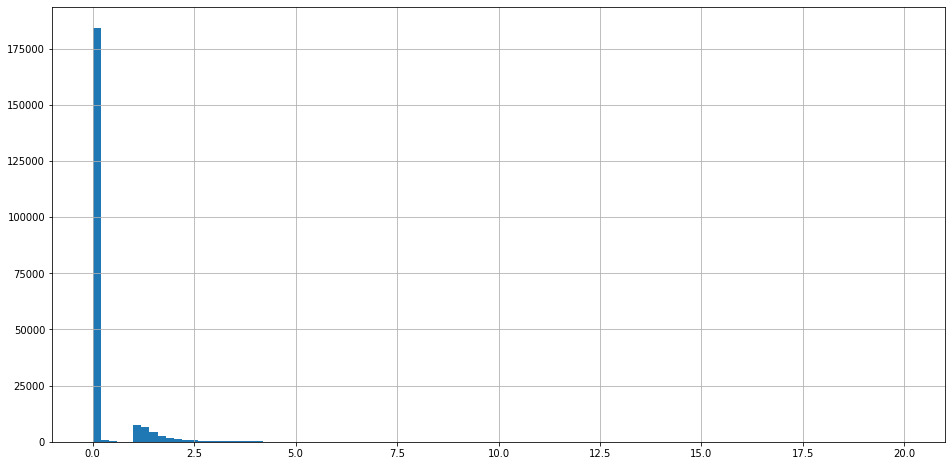

In [218]:
submission_df['item_cnt_month'].hist(bins=100, figsize=(16, 8))

In [219]:
submission_df.to_csv('submission/outputv4_fix-grid-feature-gen.csv', index=False)